Cifar10

Train + valid = 50000 images 32*32*3

Test = 10000 images 32*32*3

10 classes = [airplane, automobile, bird, cat, deer, dog, frog, horse, ship,truck]

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Load Data

In [2]:
data = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [14]:
(X, y),(X_test, y_test) = data
print(X.shape, X_test.shape, y)

(50000, 32, 32, 3) (10000, 32, 32, 3) [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [19]:
X = X.astype('float32')
X_test = X_test.astype('float32')

# Normalize
X /= 255.0
X_test /= 255.0

In [4]:
def unison_shuffle(a, b):
  inx= np.random.permutation(a.shape[0])
  return a[inx], b[inx]

In [5]:
X, y= unison_shuffle(X, y)

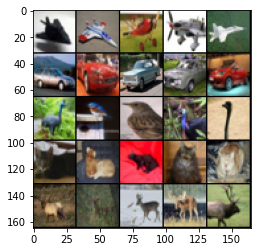

In [21]:
N = 5
final_image= np.zeros((33*N, 33*N, 3))
for c in range(N):
  class_images = X[np.hstack(y)==c]
  for i in range(N):
    final_image[c * 33 : c * 33 + 32, i * 33 : i * 33 + 32, :] = class_images[i]

plt.imshow(final_image)

#RGB to gray (NOT USED)

In [ ]:
# RGB to gray to reduce input_dim

#rgb_weights = [0.2989, 0.5870, 0.1140]
#X = np.dot(X[...,:3], rgb_weights)
#X_test= np.dot(X_test[...,:3], rgb_weights)


# Reshape (32, 32, 3) to (3072)

In [22]:
X = X.reshape(X.shape[0], 32*32*3)
X_test = X_test.reshape(X_test.shape[0], 32*32*3)
print(X.shape)

(50000, 3072)


# Split train, Valid (static)

In [23]:
split = int(X.shape[0]*.8)
X_train = X[:split]
y_train = y[:split]

X_valid = X[split:]
y_valid = y[split:]

In [25]:
Y = to_categorical(y)
Y_train = to_categorical(y_train)
Y_valid = to_categorical(y_valid)
Y_test = to_categorical(y_test)

In [26]:
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

(40000, 3072) (40000, 10) (10000, 3072) (10000, 10)


# Creat Model

In [37]:
def create_model():
  model = Sequential()
  model.add(Dense(6000, activation='relu', input_dim=32*32*3))
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
  return model

# Model train/valid


In [38]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6000)              18438000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 6000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                60010     
Total params: 18,498,010
Trainable params: 18,498,010
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(X_train, Y_train, epochs=30, batch_size= 32, validation_data=(X_valid, Y_valid))
print(history.history ['loss'][-1], history.history['acc'][-1], history.history['val_loss'][-1], history.history['val_acc'][-1])

Epoch 1/30
1250/1250 [==============================] - 14s 11ms/step - loss: 1.9371 - acc: 0.3100 - val_loss: 1.7818 - val_acc: 0.3709
Epoch 2/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.7539 - acc: 0.3769 - val_loss: 1.7137 - val_acc: 0.3922
Epoch 3/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6892 - acc: 0.4017 - val_loss: 1.6827 - val_acc: 0.4064
Epoch 4/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6385 - acc: 0.4174 - val_loss: 1.6317 - val_acc: 0.4231
Epoch 5/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6042 - acc: 0.4325 - val_loss: 1.5954 - val_acc: 0.4420
Epoch 6/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5707 - acc: 0.4442 - val_loss: 1.5668 - val_acc: 0.4521
Epoch 7/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5415 - acc: 0.4527 - val_loss: 1.5467 - val_acc: 0.4606
Epoch 8/30
1250/1250 [==========================

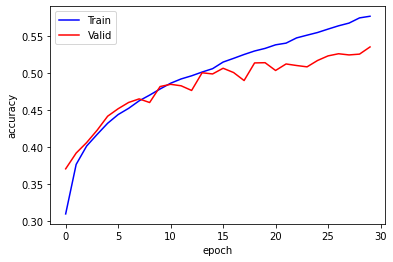

In [40]:
plt.plot(history.history['acc'], 'b-', label = "Train")
plt.plot(history.history['val_acc'], 'r-', label="Valid")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

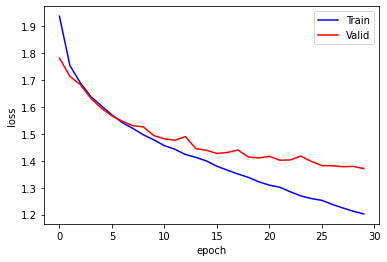

In [41]:
plt.plot(history.history['loss'], 'b-', label = "Train")
plt.plot(history.history['val_loss'], 'r-', label="Valid")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# Results(Confusion Matrix and etc)

In [42]:
# evaluate the model
x_acc = model.evaluate(X, Y, verbose=0) # all train and valid data
test_acc = model.evaluate(X_test, Y_test, verbose=0) # test data
print('Train: %.3f, Test: %.3f' % (x_acc[1], test_acc[1]))

Train: 0.616, Test: 0.535


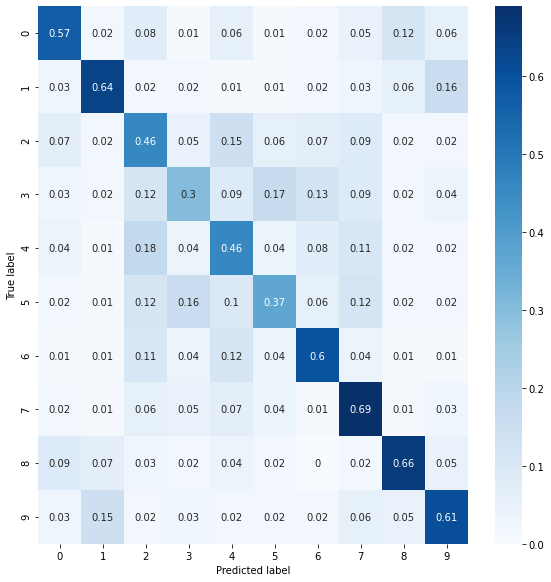

In [49]:
# Confusion Matrix
y_pred=model.predict(X_test).argmax(axis=-1)
y_test = y_test.reshape(-1)
classes = [ i for i in range(10)]

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
# precision recall f1-score
report = classification_report(np.argmax(Y_test, axis=1), y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1000
           1       0.67      0.64      0.65      1000
           2       0.38      0.46      0.42      1000
           3       0.41      0.30      0.35      1000
           4       0.41      0.46      0.44      1000
           5       0.48      0.37      0.42      1000
           6       0.59      0.60      0.59      1000
           7       0.53      0.69      0.60      1000
           8       0.66      0.66      0.66      1000
           9       0.60      0.61      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.53     10000
weighted avg       0.54      0.54      0.53     10000

